### Unconstrained sampling with $\mathrm{Normal}(0,1)$ prior:

In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, pystan as ps, matplotlib.pyplot as plt
from tqdm import trange
import scipy
%matplotlib inline
from time import time
from pylab import plot, show, legend

#### Compile Stan model:

In [2]:
sm = ps.StanModel(file="brain_Gaussian.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_094e216bcd2f5e3be629b99f112c2b47 NOW.


#### Load data from file and prepare stan data list:

In [7]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "/home/postdoc/dsen/Desktop/projeted_posterior/brain_data/data_column"+str(i+1)
    X[i] = loadtxt(name, comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

# N = 21 
# m = np.shape(X)[1]
# p = 10
# a = 1/m
# data = dict(N=N, R=m, d=p, X=X[:N], alpha=1/m, lmbda=0.5)

N = 21 
m = 10
p = 5
a = 1/m
data = dict(N=N, p=p, m=m, a=a, X=X[:N,:m,:m])

print(np.mean(X[:N,:m,:m]))

0.5571428571428572


#### Sample using stan:

In [8]:
control = dict(max_treedepth=10)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=3, chains=3, iter=1_000, init="random")
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

33.37 minutes to run
Inference for Stan model: anon_model_094e216bcd2f5e3be629b99f112c2b47.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]       -339.2   33.38 204.73 -845.8 -446.2 -289.4 -186.0 -80.44     38   1.06
Z[2,1]       -80.62    7.72  53.15 -224.0 -104.6 -68.19 -42.38 -15.43     47   1.06
Z[3,1]       260.92   27.58 181.26  52.11  134.6 214.96 338.16 750.24     43   1.07
Z[4,1]        13.49     1.5  20.23 -25.27   1.79  10.89  24.27  62.39    183   1.01
Z[5,1]        10.73    3.19  42.01 -75.79 -12.35   8.63  32.58  97.07    174   1.02
Z[6,1]       -81.89    7.28  51.17 -210.2 -106.3 -70.14  -44.6 -18.53     49   1.05
Z[7,1]       258.15   23.31 161.61  57.27 139.96 219.38 338.66 675.01     48   1.06
Z[8,1]       229.17   24.56 163.13  41.27  109.4 182.18  306.6 641.45     44   1.06
Z[9,1]       237.64   23.98 163.66  

#### Plot posterior means of $U$'s:

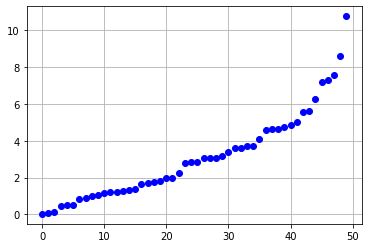

In [9]:
plt.plot(np.sort(np.abs(np.mean(trace['u'],0)).flatten()), 'bo')
plt.grid(True)

#### Look at Stan fit:

In [12]:
fit.get_sampler_params()

[OrderedDict([('accept_stat__',
               array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                      1.00000000e+00, 1.00000000e+00, 7.14285714e-01, 1.00000000e+00,
                      5.00000000e-01, 9.94817796e-01, 6.74990214e-01, 8.45979323e-01,
                      1.00000000e+00, 2.50000000e-01, 1.00000000e+00, 9.98817677e-01,
                      3.18083476e-02, 1.00000000e+00, 9.98721082e-01, 9.50812483e-01,
                      6.13521319e-01, 9.99014343e-01, 9.07931911e-01, 1.12126118e-01,
                      9.86977784e-01, 9.98684644e-01, 7.02921285e-01, 9.98379666e-01,
                      7.35815294e-01, 7.87257092e-01, 9.99944620e-01, 1.66666694e-01,
                      9.91620418e-01, 8.48424264e-01, 8.83748312e-01, 6.37286128e-01,
                      9.00235113e-01, 9.99037042e-01, 1.57009372e-01, 9.95890506e-01,
                      9.36905833e-01, 9.27540135e-01, 9.78466743e-01, 1.73412848e-02,
                      

In [14]:
np.shape(trace['u'])

(2000, 40, 3)

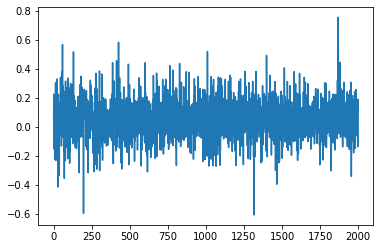

In [13]:
i, j = 1, 3
n = 20

π = trace['Z'][:,i,j] + \
         [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
          for idx in range(np.shape(trace['u'])[0])]
plt.plot(π);

In [7]:
π_chain = np.zeros((np.shape(trace['u'])[0], N,m,m))
for n in range(N) :
    for i in range(m) :
        for j in range(m) :
            π_chain[:,n,i,j] = trace['Z'][:,i,j] + \
                          [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
                           for idx in range(np.shape(trace['u'])[0])]

In [8]:
ll = np.zeros(np.shape(trace['u'])[0])
probs = 1/(1+np.exp(-π_chain))
for itr in range(len(ll)) :
    ll[itr] = np.sum(X*np.log(probs[itr]) + (1-X)*np.log(1-probs[itr]))

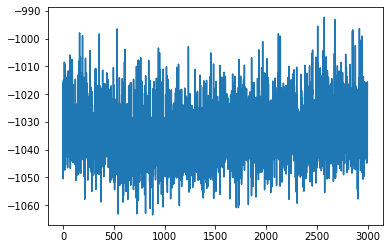

In [9]:
plt.plot(ll)

In [10]:
np.shape(trace['u'])

(3000, 10, 4)

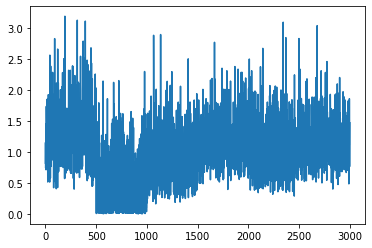

In [11]:
i = 2
plt.plot([scipy.linalg.norm(trace['u'][itr,i,:]) for itr in range(np.shape(trace['u'])[0])])

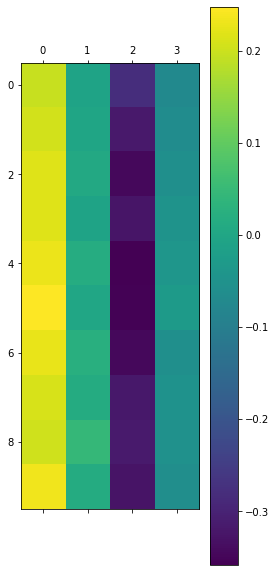

In [12]:
plt.matshow(np.mean(trace['u'],0))
plt.colorbar()

In [18]:
"a"+str(1)

'a1'